## Embedding Space Visualizations And Interpretations

Let's play with the embedding space of the MLP model trained in MLP.ipynb. 

We won't use more advanced models/training techniques, only what's in the MLP notebook. We will use the embeddings of the model to visualize the embedding space and interpret the results.

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

In [16]:
words = open('../data/names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [17]:
nbr_neurons = 256
vocab_size = 27
emb_dim = 2
block_size = 3 # context window size

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) 

8785

In [18]:
# build the dataset

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Let's first train the model 

In [19]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, Ci = [], [], []

In [20]:
n = 20000
batch_size = 32


for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None 

    loss.backward()

    # update
    l = 0.1 if i < 300000 else 0.01
    #l = 0.01
    for p in parameters:
        p.data += -0.1 * p.grad 

    stepi.append(i)
    lossi.append(loss.item())
    C_clone = C.detach().clone()
    Ci.append(C_clone)

print(loss)

tensor(2.3107, grad_fn=<NllLossBackward0>)


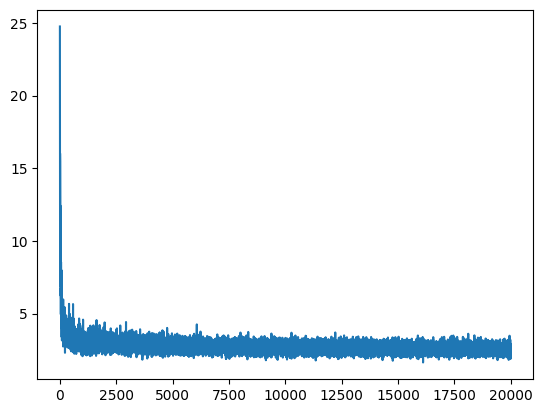

In [21]:
plt.plot(stepi, lossi)

In [22]:
def model_test(X,Y):
    emb = C[X] 
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y) 
    return loss

ldev = model_test(Xdev, Ydev)
ltest = model_test(Xte, Yte)

ldev, ltest

(tensor(2.4938, grad_fn=<NllLossBackward0>),
 tensor(2.4891, grad_fn=<NllLossBackward0>))

### Now that we have the 2D embeddings, let's visualize them

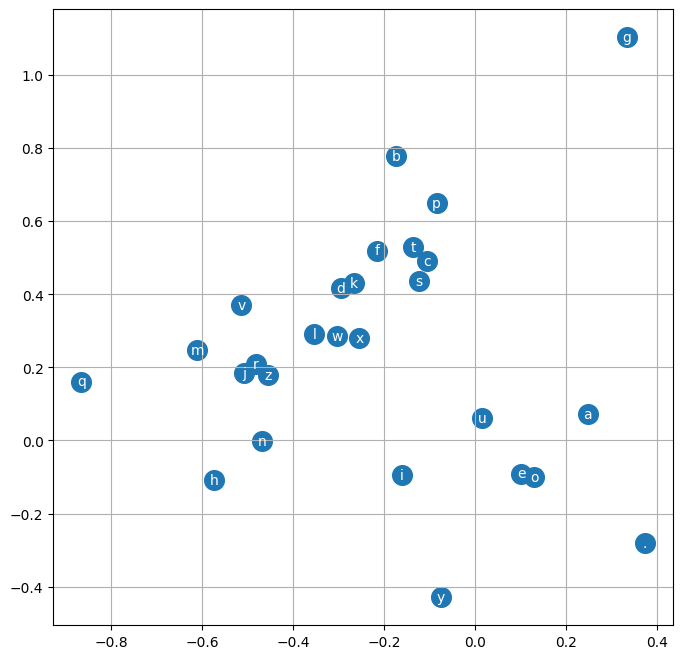

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

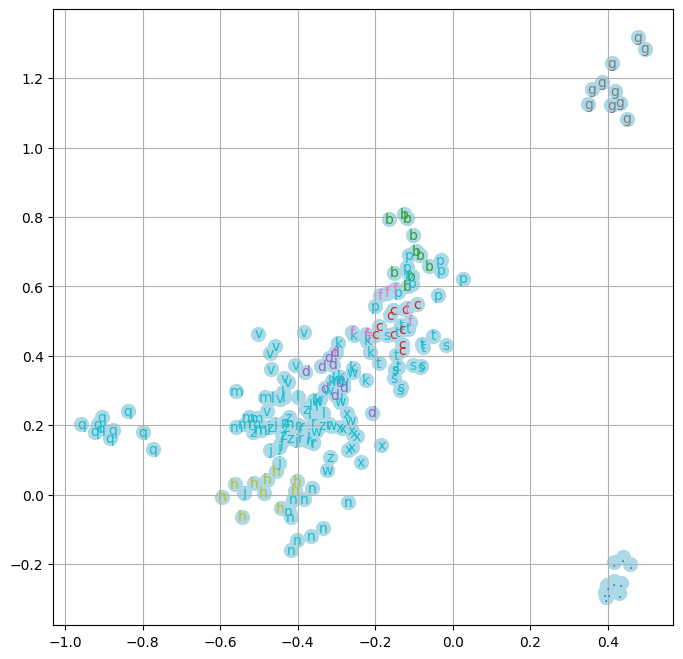

In [24]:
# evolution of vowels trhoughout time 
voc = list(range(27))
v = ["a", "e", "i", "o", "u", "y"]
vows = [stoi[s] for s in v]
cons = [i for i in voc if i not in vows]

plt.figure(figsize=(8,8))
# assign a unique color to each character among the first 5 embeddings using a colormap
colors = {}
for j in cons:
    colors[itos[j]] = plt.cm.tab10(j)

for i in range(10000, n, 1000):
    for j in cons:
        plt.scatter(Ci[i][j,0].data, Ci[i][j,1].data, s=100, color="lightblue")
        plt.text(Ci[i][j,0].item(), Ci[i][j,1].item(), itos[j], ha="center", va="center", color=colors[itos[j]])
plt.grid("minor")

# It's hard to get meaningful hindsight in 2D 

### Let's scale the dimensions

In [25]:
nbr_neurons = 256
vocab_size = 27
emb_dim = 3
block_size = 3 # context window size

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) 

9580

In [26]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, Ci = [], [], []

In [27]:
n = 100000
batch_size = 32


for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None 

    loss.backward()

    # update
    l = 0.1 if i < 50000 else 0.01
    #l = 0.01
    for p in parameters:
        p.data += -l * p.grad 

    stepi.append(i)
    lossi.append(loss.item())
    C_clone = C.detach().clone()
    Ci.append(C_clone)

print(loss)

tensor(2.1716, grad_fn=<NllLossBackward0>)


In [28]:
ldev = model_test(Xdev, Ydev)
ltest = model_test(Xte, Yte)

ldev, ltest

(tensor(2.2436, grad_fn=<NllLossBackward0>),
 tensor(2.2432, grad_fn=<NllLossBackward0>))

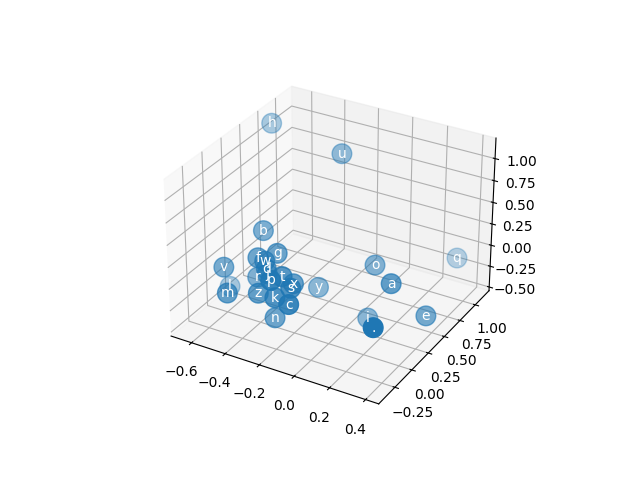

In [ ]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(C[:,0].data, C[:,1].data, C[:,2].data, s=200)
for i in range(C.shape[0]):
    ax.text(C[i,0].item(), C[i,1].item(), C[i,2].item(), itos[i], ha="center", va="center", color="white")
ax.grid(True)
plt.show()

# It's fun but i struggle to interpret 
# Maybe this would be easier with words 

In [43]:
nbr_neurons = 256
vocab_size = 27
emb_dim = 5
block_size = 3 # context window size

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim*block_size, nbr_neurons), generator=g)
b1 = torch.randn(nbr_neurons, generator=g)
W2 = torch.randn((nbr_neurons, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) 

for p in parameters:
        p.requires_grad = True 
stepi, lossi, Ci = [], [], []

In [47]:
n = 100000
batch_size = 32


for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Forward pass 
    emb = C[Xtr[ixs]] 
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None 

    loss.backward()

    # update
    l = 0.1 if i < 50000 else 0.01
    #l = 0.01
    for p in parameters:
        p.data += -l * p.grad 

    stepi.append(i)
    lossi.append(loss.item())
    C_clone = C.detach().clone()
    Ci.append(C_clone)

print(loss)

tensor(2.2241, grad_fn=<NllLossBackward0>)


In [48]:
ldev = model_test(Xdev, Ydev)
ltest = model_test(Xte, Yte)

ldev, ltest

(tensor(2.1798, grad_fn=<NllLossBackward0>),
 tensor(2.1800, grad_fn=<NllLossBackward0>))

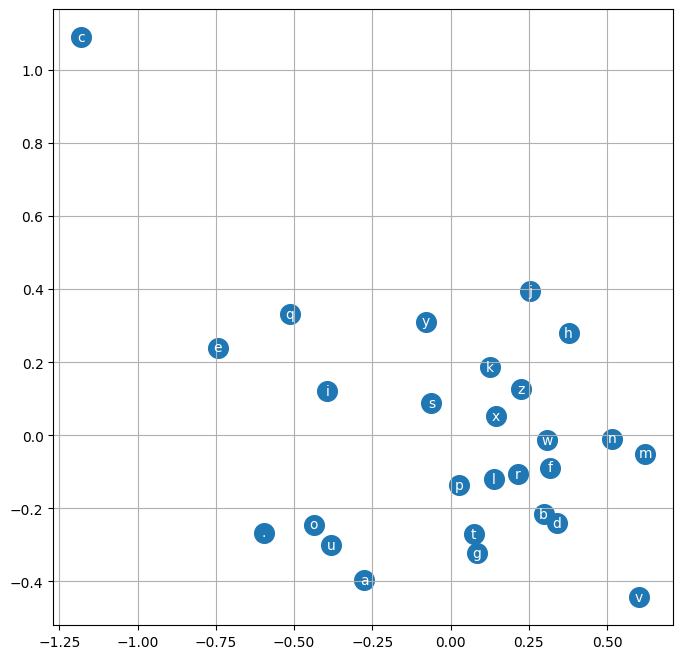

Explained variance ratio for PC1: 0.40430235862731934
Explained variance ratio for PC2: 0.28761547803878784
Explained variance ratio for PC3: 0.11965614557266235
Total explained variance for the first two components: 0.6919178366661072


In [49]:
# Center the embeddings
C_centered = C - C.mean(dim=0, keepdim=True)

# Compute SVD on the centered embeddings
U, S, V = torch.linalg.svd(C_centered)

# Project onto the first two principal components
C_pca = torch.matmul(C_centered, V[:, :2])

# Plot the 2D projection
plt.figure(figsize=(8,8))
plt.scatter(C_pca[:, 0].data, C_pca[:, 1].data, s=200)
for i in range(C_pca.shape[0]):
    plt.text(C_pca[i, 0].item(), C_pca[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid(True)
plt.show()

# Compute explained variance ratio for the principal components
explained_variance = S**2
explained_variance_ratio = explained_variance / explained_variance.sum()

print("Explained variance ratio for PC1:", explained_variance_ratio[0].item())
print("Explained variance ratio for PC2:", explained_variance_ratio[1].item())
print("Explained variance ratio for PC3:", explained_variance_ratio[2].item())
print("Total explained variance for the first two components:",
    (explained_variance_ratio[0] + explained_variance_ratio[1]).item())

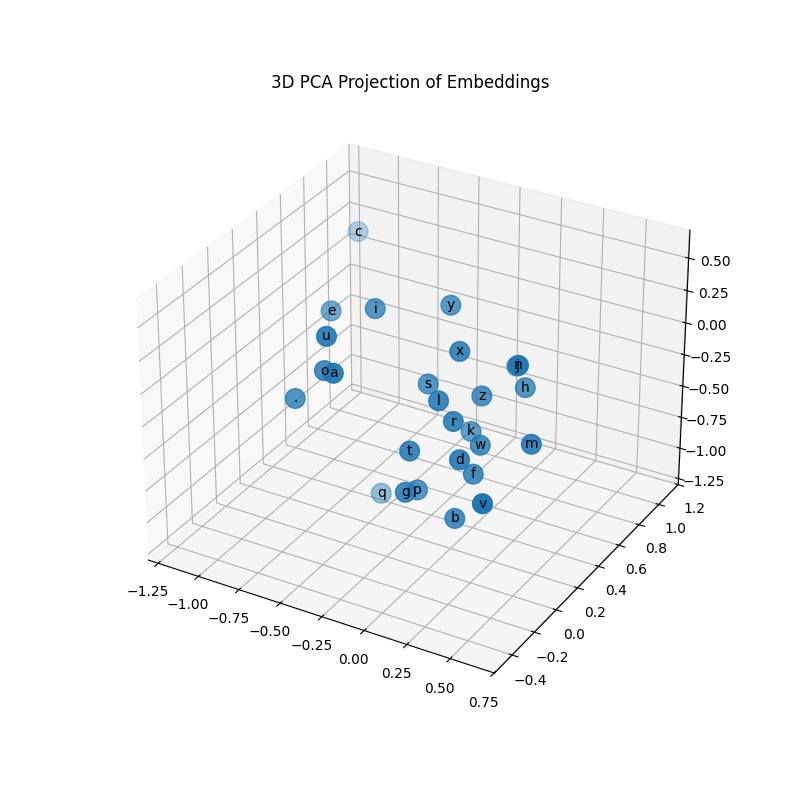

In [75]:
%matplotlib widget

C_pca3 = torch.matmul(C_centered, V[:, :3])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(C_pca3[:,0].data, C_pca3[:,1].data, C_pca3[:,2].data, s=200)
for i in range(C_pca3.shape[0]):
    ax.text(C_pca3[i,0].item(), C_pca3[i,1].item(), C_pca3[i,2].item(), itos[i],
            ha='center', va='center', color='black')
ax.set_title("3D PCA Projection of Embeddings")
plt.show()

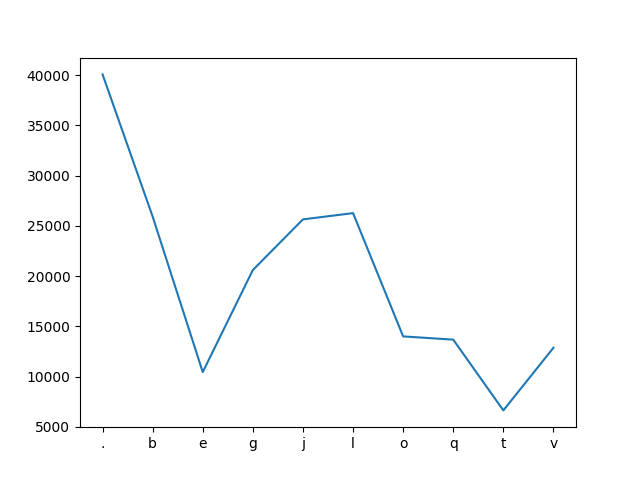

((10,), (11,))

In [88]:
# Maybe if we get some stats on the letters in the document, we will understand the plots better
import numpy as np

raw_chars = [s for s in ''.join(words)]
counts, bin_edges = np.histogram([stoi[s] for s in raw_chars])
plt.figure()
plt.plot([itos[int(bin_edges[i]) - 1] for i in range(len(counts))], counts)
plt.show()
counts.shape, bin_edges.shape